# Time-frequency analysis
## Evoked 

We can create ERPs on Epochs object by calling the [epochs.average()](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.average) function. 

Visit MNE-Python documentation for tutorials related to ERPs [here](https://mne.tools/stable/auto_tutorials/evoked/10_evoked_overview.html). 

Note: frontal channels that are close to the forehead are noisy even after preprocessing. We should skip them before calculating ERPs.

TODO: plot_joint() and GFP could be interesting, ROIs

In [22]:
import os
import mne
import numpy as np

%matplotlib qt

In [11]:
# Read epochs
epochs_path = '/Volumes/crnl-memo-hd/TMS_rewiring/preprocessed/epochs_asrt'
epochs_filename = '30_E_Day1_ICA_autoreject_ransac-epo.fif.gz'


epochs = mne.read_epochs(os.path.join(epochs_path, epochs_filename), preload=False)

Reading /Volumes/crnl-memo-hd/TMS_rewiring/preprocessed/epochs_asrt/30_E_Day1_ICA_autoreject_ransac-epo.fif.gz ...
    Found the data of interest:
        t =    -250.00 ...     750.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
Replacing existing metadata with 6 columns
1561 matching events found
No baseline correction applied
0 projection items activated


In [57]:
# Based on the metadata we can filter stimuli that are not followed by an incorrect answer

epochs_correct_answers = epochs["answer == 'correct'"]

In [67]:
# Do we need to equalize event counts??
epochs_correct_answers.equalize_event_counts?

In [61]:
# This is how to equalize the number of trials in each condition (L, H).
stimuli_L = np.unique(epochs.metadata.loc[epochs.metadata['triplet'] == 'L', 'id']).tolist()
stimuli_H = np.unique(epochs.metadata.loc[epochs.metadata['triplet'] == 'H', 'id']).tolist()

epochs_correct_answers.events = mne.merge_events(epochs_correct_answers.events, stimuli_L, 12, replace_events=True)
epochs_correct_answers.events = mne.merge_events(epochs_correct_answers.events, stimuli_H, 10, replace_events=True)

epochs_correct_answers.equalize_event_counts(['12', '10'])

[10, 11, 14, 15]

In [68]:
epochs_correct_answers

<EpochsFIF |  782 events (all good), -0.25 - 0.75 sec, baseline [-0.25, 0] sec, ~94 kB, data not loaded, with metadata,
 '10': 391
 '11': 0
 '12': 391
 '14': 0
 '15': 0
 '16': 0>

In [69]:
ch_names = ['F7', 'F5', 'F3', 'FC5', 'FC3',
           'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2',
           'F4', 'F6', 'F8', 'FC4', 'FC6',
           'FT7', 'T7', 'TP7', 
           'C3', 'Cz', 'C4',
           'FT8', 'T8', 'TP8',
           'CP5', 'CP3', 'P7', 'P5', 'P3',
           'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2',
           'CP4', 'CP6', 'P4', 'P6', 'P8',
           'PO3', 'PO7', 'O1',
           'PO4', 'PO8', 'O2',]

epochs_evoked = epochs_correct_answers.copy().load_data().pick_channels(ch_names, ordered=True)


Loading data for 782 events and 501 original time points ...


In [25]:
#epochs_evoked.plot_sensors(show_names=True)

In [70]:
epochs_evoked

<EpochsFIF |  782 events (all good), -0.25 - 0.75 sec, baseline [-0.25, 0] sec, ~140.6 MB, data loaded, with metadata,
 '10': 391
 '11': 0
 '12': 391
 '14': 0
 '15': 0
 '16': 0>

In [71]:
evoked_epoch_1_H = epochs_evoked["epoch == 1 & triplet == 'H'"].average()

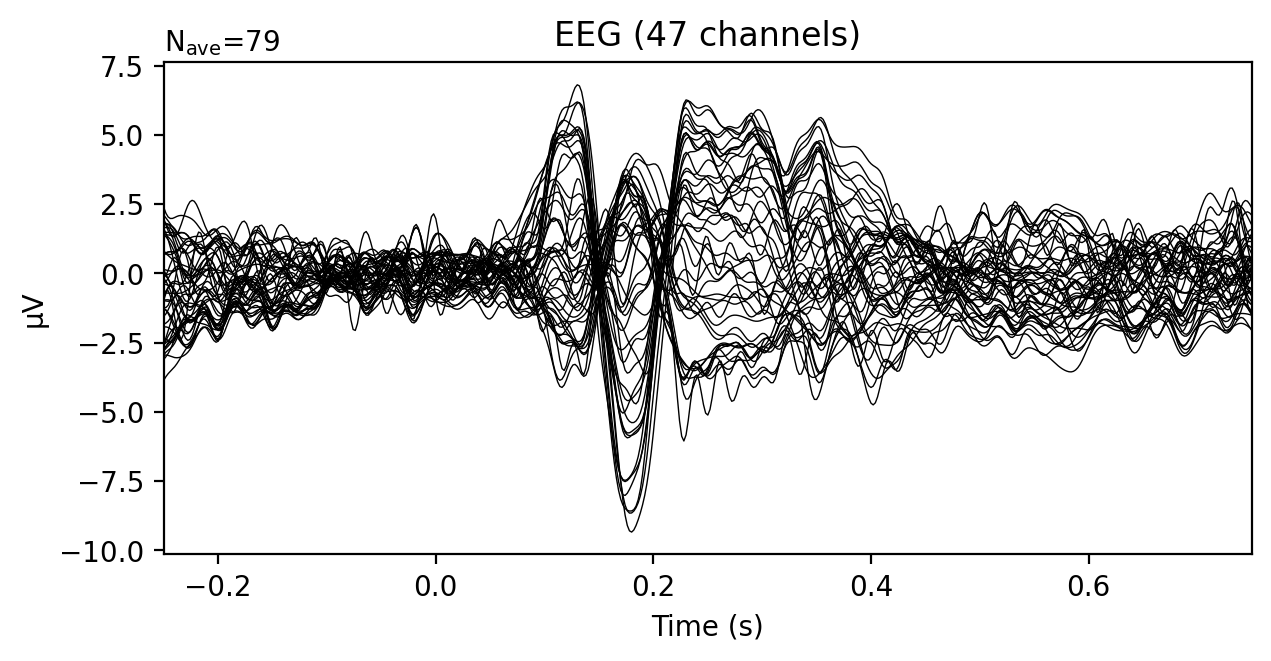

In [72]:
evoked_epoch_1_H.detrend().plot()

No projector specified for this dataset. Please consider the method self.add_proj.


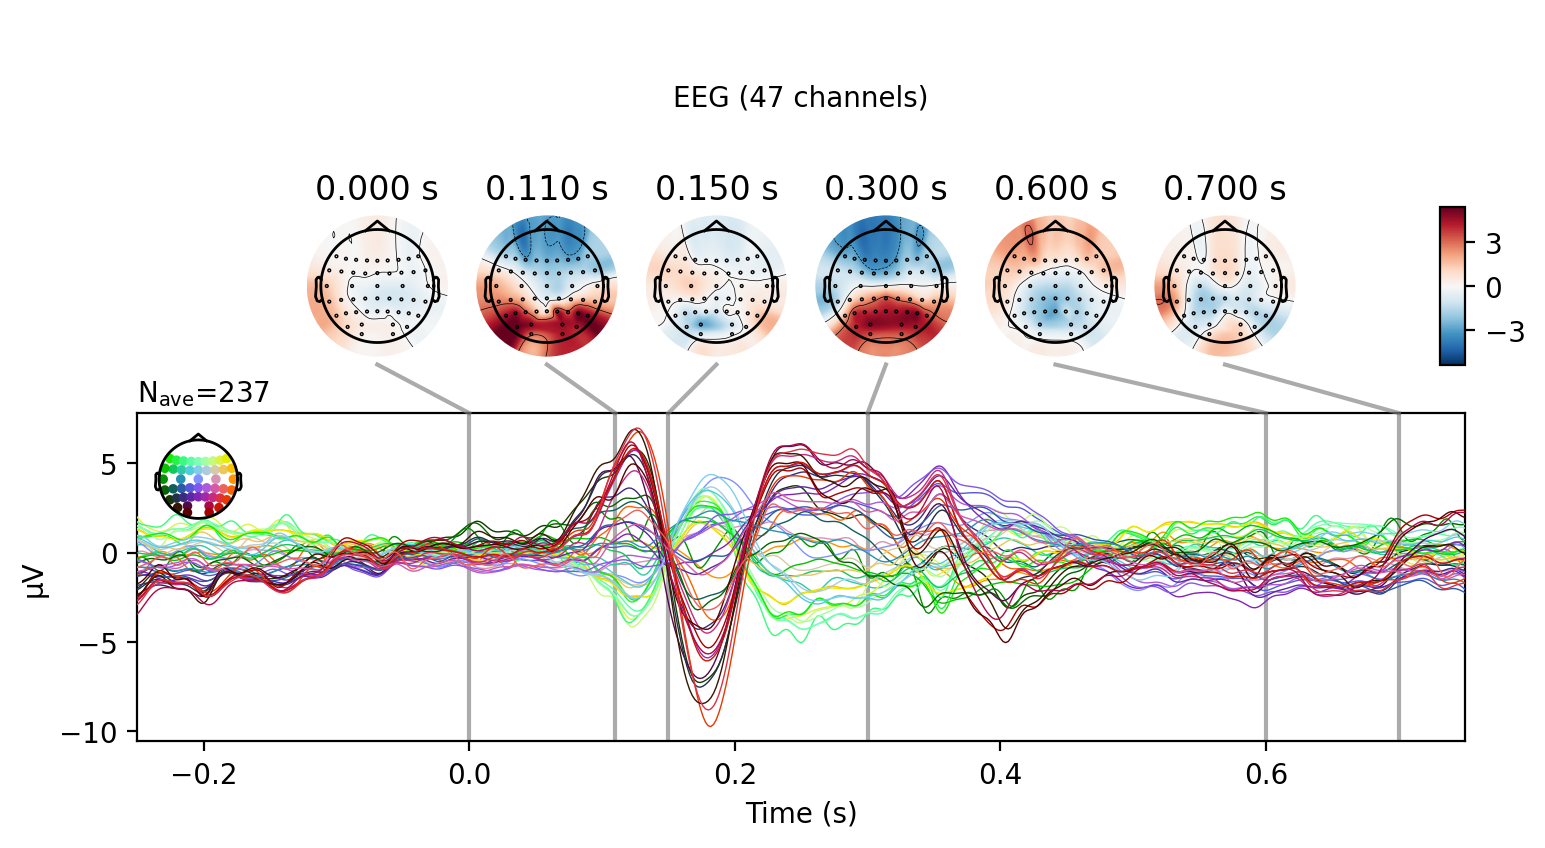

In [27]:
evoked_epoch_1_H.detrend().plot_joint(times=[0.0, 0.11, 0.15, 0.3, 0.6, 0.7])

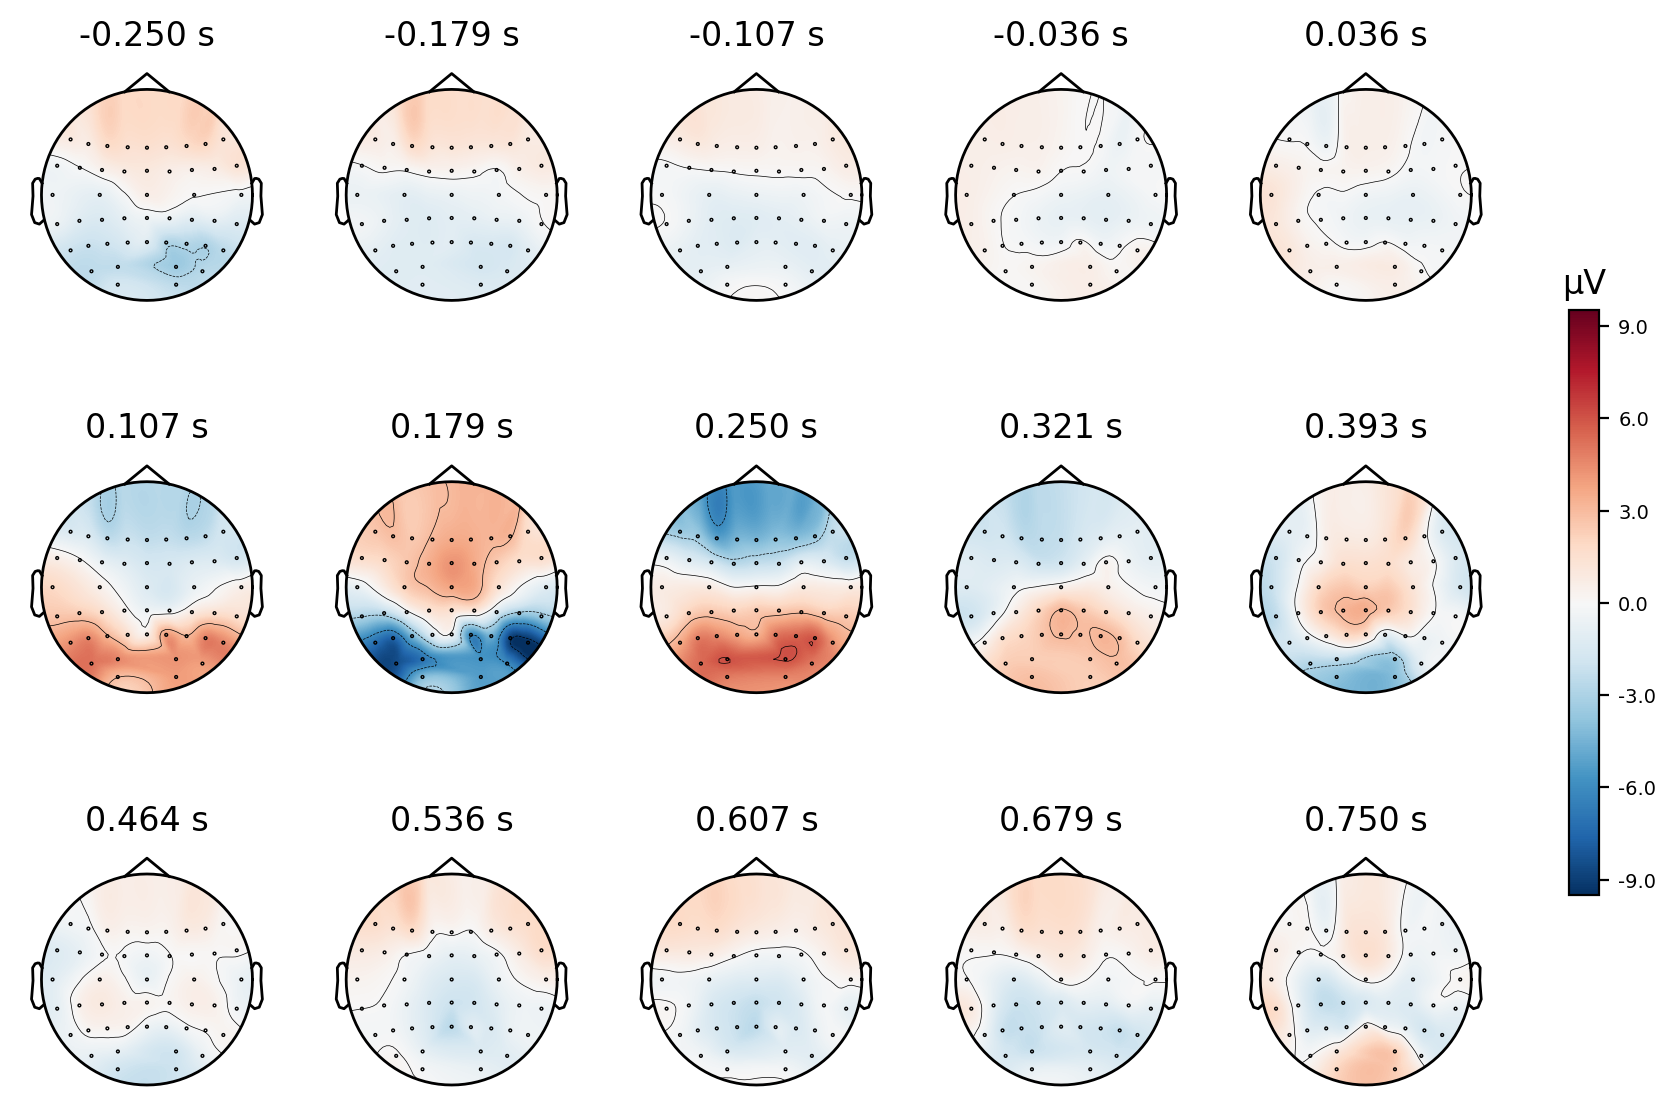

In [30]:
#import numpy as np
times = np.linspace(-0.25, 0.75, 15)
evoked_epoch_1_H.plot_topomap(times=times, ch_type='eeg', nrows=3,)
#fig.savefig('evoked_10_topomap.png', dpi=200)

In [40]:
fig, anim = evoked_epoch_1_H.animate_topomap(
    times=times, ch_type='eeg', frame_rate=2, time_unit='s', blit=False, butterfly=True, show=True)

Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...


## Power

In [42]:
from mne.time_frequency import tfr_morlet

freqs = np.logspace(*np.log10([4, 45]), num=12)
n_cycles = freqs / 2.  # different number of cycle per frequency


power, itc = tfr_morlet(epochs_evoked["epoch == 1 & triplet == 'H'"], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=2, n_jobs=8)


power_f_corrected = np.zeros_like(power.data)
# divide power by 1/f
for e in range(power.data.shape[0]):
    for f in range(power.data.shape[1]):
        power_f_corrected[e][f] = power.data[e][f] / (1/power.freqs[f])

power.data = power_f_corrected

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:    7.7s finished


Applying baseline correction (mode: logratio)


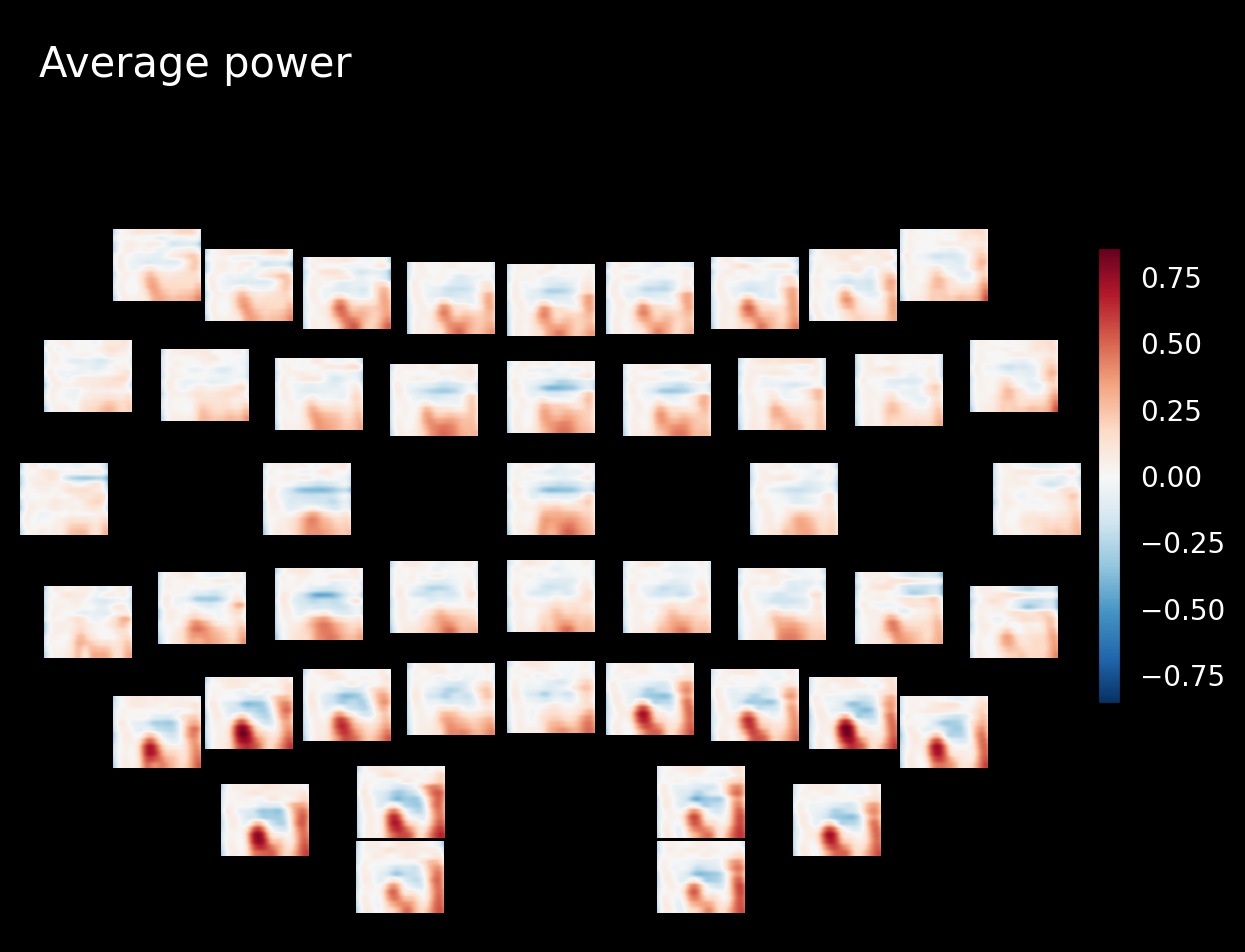

/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:224: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:224: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)


In [43]:
power.plot_topo(baseline=(-0.25, 0), mode='logratio', title='Average power')

In [ ]:
power.plot_joint(baseline=(-0.25, 0), mode='logratio', tmin=-.25, tmax=0.75)